In [2]:
import pandas as pd
from Bio import SeqIO
import re
import json
import numpy as np
import matplotlib.pyplot as plt
# reload all changed moduels
%load_ext autoreload
%autoreload 2   


## protein sequences and incubation temperature

# source data:
retrieve genome report from 'data/prokaryotes.txt'

# output:
data/genome_report.joson -> data/temperature_mask

In [3]:
from process_data import ProcessData
client = ProcessData()

In [16]:
# retrieve genome report from 'data/prokaryotes.txt'
meta_data = client.genome_report('data/prokaryotes.txt')

Number of genome: 2221


In [ ]:
# retrieve data from ATCC and save them into json
json_file = client.retrieve_atcc()

## analyze genome report

In [6]:
# output is genome_report.json
with open('data/genome_report.json', 'r') as f:
    data = json.load(f)
# 
from collections import Counter
temp = [max(item['incubation_temperature']) for item in data if 'incubation_temperature' in item]

temp2 = dict(sorted(Counter(temp).items(), key=lambda x: x[0]))
temp2

{4: 1,
 5: 1,
 10: 1,
 15: 8,
 18: 5,
 20: 12,
 22: 1,
 23: 1,
 24: 2,
 25: 3,
 26: 342,
 27: 1,
 28: 7,
 29: 1,
 30: 285,
 34: 1,
 35: 23,
 37: 1133,
 40: 1,
 45: 1,
 50: 2,
 55: 6,
 60: 5,
 65: 1,
 70: 5,
 80: 4}

In [7]:
[item for item in data if 'incubation_temperature' in item and item['incubation_temperature'] == [4]]

[{'#Organism/Name': 'Polaribacter filamentus',
  'TaxID': 53483,
  'BioProject Accession': 'PRJNA355329',
  'BioProject ID': 355329,
  'Group': 'FCB group',
  'SubGroup': 'Bacteroidota/Chlorobiota group',
  'Size (Mb)': 4.28193,
  'GC%': '31.4',
  'Replicons': '-',
  'WGS': 'MQUA01',
  'Scaffolds': '15',
  'Genes': '3918',
  'Proteins': '3669',
  'Release Date': '2018/02/26',
  'Modify Date': '2022/07/17',
  'Status': 'Contig',
  'Center': 'Atmosphere and Ocean Research Institute, The University of Tokyo',
  'BioSample Accession': 'SAMN06074323',
  'Assembly Accession': 'GCA_002943715.1',
  'Reference': 'REPR',
  'FTP Path': 'ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/002/943/715/GCF_002943715.1_ASM294371v1',
  'Pubmed ID': '-',
  'Strain': 'ATCC 700397',
  'ATCC_No': '700397',
  'incubation_temperature': [4]}]

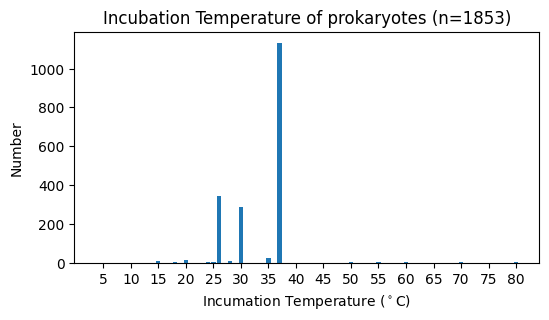

In [11]:
plt.figure(figsize=(6,3))
plt.bar(list(temp2), temp2.values())
plt.title(f"Incubation Temperature of prokaryotes (n={len(temp)})")
plt.xlabel("Incumation Temperature ($^\circ$C)")
plt.ylabel("Number")
plt.xticks(range(5,81,5))
plt.show()

In [12]:
for item in data:
    print(item['FTP Path'])
    break

ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/215/245/GCA_900215245.1_IMG-taxon_2617270901_annotated_assembly


## prepare protein

In [23]:
# prepare protein ~ temperature data
client = ProcessData()
aa_meta = client.get_meta()
print('Number of species in genome report: ', len(aa_meta))
print(aa_meta['Pseudomonas fluorescens'])

4442
Number of species in genome report:  1083
('Pseudomonas fluorescens', ['26'], '/home/yuan/data/ftp.ncbi.nlm.nih.gov/genomes/all/GCF/001/414/285/GCF_001414285.1_ATCC948-1/GCF_001414285.1_ATCC948-1_protein.faa.gz')


In [24]:
client.prepare_aa(aa_meta)

species=1083, proteins=1590198


In [25]:
# check protein sequence of a certain genome
import gzip
infile = '/home/yuan/data/ftp.ncbi.nlm.nih.gov/genomes/all/GCA/900/117/375/GCA_900117375.1_SSCIU/GCA_900117375.1_SSCIU_translated_cds.faa.gz'
with gzip.open(infile, 'rt') as f:
    for rec in SeqIO.parse(f, 'fasta'):
        print(rec.description)
        break

lcl|FPED01000005.1_prot_SFV45968.1_1 [locus_tag=SSCIU_02811] [protein=Hypothetical protein] [protein_id=SFV45968.1] [location=complement(193..558)] [gbkey=CDS]


In [27]:
# prepare protein ~ temperature data for masked models
# output: data/temperature_mask/temperature_mask.txt
client = ProcessData()
aa_meta = client.get_meta()
client.prepare_aa_mask(aa_meta)

4442
species=1083, proteins=1590198


## uniportKB annotations
input: uniprot_sprot.dat.gz

In [73]:
from Bio import SeqIO
import gzip

# amino acids in sequence > 24
n=0
kmer=512
infile = '/home/yuan/data/downloads/UniProt/uniprot_sprot.dat.gz'
with gzip.open(infile, 'rb') as IN, open('./data/uniprot_sprot.txt', 'w') as OUT, \
    open('./data/temperature_mask/uniprot_sprot_mask.txt', 'w') as MASK:
    for rec in SeqIO.parse(IN, 'swiss'):
        annot, temp = None, None
        annot = rec.annotations
        _seq = str(rec.seq)
        if 'comment' in annot:
            for i in annot['comment'].split('; '):
                temp = re.findall(r'Optimum temperature is (\d+-\d+|\d+)', i)
                # if rec.id == 'Q8YYI3':
                #     print(temp, i)
                if temp and len(_seq) > 24:
                    # annotations
                    i=i.replace('\t', '')
                    desc=rec.description.replace('\t', '')
                    items = [_seq, temp[0], rec.id]
                    line = '\t'.join(items)
                    OUT.write(line+"\n")
                    # mask file
                    temp = np.max([int(t) for t in temp[0].split('-')])
                    if len(_seq) > kmer:
                        for j in range(0, len(_seq)-kmer):
                            MASK.write(f"{_seq[j:j+kmer]} is {temp}\n")    
                    else:
                        MASK.write(f"{_seq} is {temp}\n")
                    n += 1
                    break
print(f"Total UniProt-Sprot protein: {n}.")

Total UniProt-Sprot protein: 2110.


In [81]:
from collections import Counter, OrderedDict
import pandas as pd

counts, info = {}, {}
with open('./data/uniprot_sprot.txt', 'r') as f:
    for line in f:
        line = line.rstrip()
        aa, aa_temp, acc = line.split('\t')
        temp = int(aa_temp.split('-')[-1])
        if temp not in counts:
            counts[temp] = Counter()
            info[temp] = 0
        counts[temp].update(aa)
        info[temp] += 1
cdf = pd.DataFrame(counts).fillna(0).sort_index().sort_index(axis=1)
print(cdf.shape)
print(cdf)

(22, 82)
     4     7     9      10     15     16    18      20    21     22   ...  \
A  123.0  44.0  35.0  139.0  146.0   80.0   5.0  1016.0  43.0  560.0  ...   
C   26.0  12.0  11.0   22.0   11.0   15.0  14.0   219.0  12.0  152.0  ...   
D  124.0  23.0  37.0   87.0   76.0   60.0   5.0   631.0  26.0  413.0  ...   
E  117.0  37.0  33.0  113.0   71.0   71.0   6.0   708.0  48.0  450.0  ...   
F  102.0  33.0  25.0   67.0   46.0   37.0   6.0   482.0  25.0  324.0  ...   
G  128.0  29.0  39.0  104.0  110.0   71.0   8.0   977.0  40.0  606.0  ...   
H   59.0   6.0  16.0   42.0   40.0   20.0   2.0   282.0   8.0  164.0  ...   
I  116.0  32.0  27.0   89.0   55.0   51.0   4.0   657.0  27.0  412.0  ...   
K   94.0  24.0  25.0   85.0   48.0   63.0  12.0   563.0  39.0  379.0  ...   
L  172.0  57.0  59.0  140.0  108.0  108.0   6.0  1100.0  49.0  616.0  ...   
M   34.0   9.0  23.0   33.0   23.0   25.0   2.0   266.0  15.0  183.0  ...   
N  117.0  17.0  14.0   68.0   45.0   35.0   4.0   506.0  19.0  307.

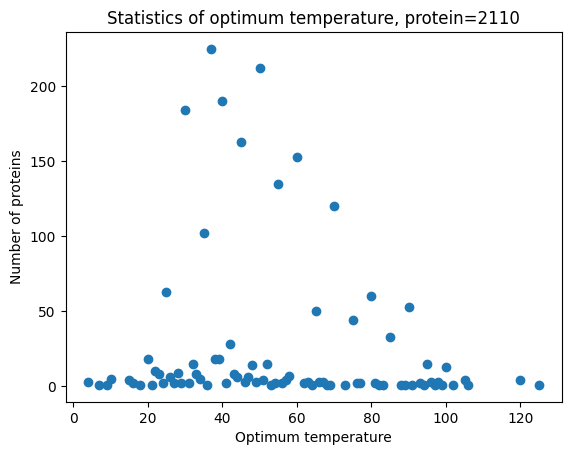

In [89]:
plt.scatter(info.keys(), info.values())
plt.title(f'Statistics of optimum temperature, protein={sum(info.values())}')
plt.xlabel('Optimum temperature')
plt.ylabel('Number of proteins')
plt.show()

In [79]:
per_cdf=cdf/cdf.sum(axis=0)
per_cdf

,4,7,9,10,15,16,18,20,21,22,...,96,97,98,99,100,102,105,106,120,125
A,0.061286,0.080882,0.063521,0.088591,0.118989,0.077519,0.040984,0.081502,0.077477,0.075279,...,0.110365,0.060241,0.064397,0.042857,0.066414,0.064455,0.069700,0.052083,0.091165,0.062257
C,0.012955,0.022059,0.019964,0.014022,0.008965,0.014535,0.114754,0.017568,0.021622,0.020433,...,0.001919,0.006024,0.004441,0.001299,0.004352,0.000948,0.004840,0.041667,0.015977,0.019455
D,0.061784,0.042279,0.067151,0.055449,0.061940,0.058140,0.040984,0.050618,0.046847,0.055518,...,0.054702,0.060241,0.051073,0.050649,0.051845,0.066351,0.053727,0.041667,0.044173,0.035019
E,0.058296,0.068015,0.059891,0.072020,0.057865,0.068798,0.049180,0.056794,0.086486,0.060492,...,0.081574,0.096386,0.089563,0.096104,0.102176,0.072986,0.080833,0.135417,0.079887,0.108949
F,0.050822,0.060662,0.045372,0.042702,0.037490,0.035853,0.049180,0.038665,0.045045,0.043554,...,0.028791,0.042169,0.030348,0.048052,0.045222,0.045498,0.050823,0.020833,0.039474,0.046693
G,0.063777,0.053309,0.070780,0.066284,0.089650,0.068798,0.065574,0.078373,0.072072,0.081463,...,0.099808,0.090361,0.079201,0.040260,0.066036,0.063507,0.070668,0.093750,0.092105,0.070039
H,0.029397,0.011029,0.029038,0.026769,0.032600,0.019380,0.016393,0.022622,0.014414,0.022046,...,0.013436,0.030120,0.023686,0.014286,0.019111,0.011374,0.020813,0.010417,0.013158,0.027237
I,0.057798,0.058824,0.049002,0.056724,0.044825,0.049419,0.032787,0.052703,0.048649,0.055384,...,0.058541,0.072289,0.072539,0.093506,0.080416,0.066351,0.063408,0.104167,0.056391,0.085603
K,0.046836,0.044118,0.045372,0.054175,0.039120,0.061047,0.098361,0.045163,0.070270,0.050948,...,0.067179,0.072289,0.072539,0.115584,0.077956,0.083412,0.064376,0.052083,0.054511,0.070039
L,0.085700,0.104779,0.107078,0.089229,0.088020,0.104651,0.049180,0.088240,0.088288,0.082807,...,0.081574,0.078313,0.091044,0.102597,0.089120,0.063507,0.106970,0.072917,0.078008,0.050584


In [202]:
from scipy import stats

def aa_corr(x, y):
    corr = stats.pearsonr(x, y)
    # print(dir(corr))
    return pd.Series([corr.statistic, corr.pvalue, corr.correlation])
print(list(per_cdf))
corr =  per_cdf.apply(aa_corr, y=list(per_cdf), axis=1)
corr = pd.DataFrame(corr)
corr.columns=['statistic', 'pvalue', 'correlation']
corr.index = list(per_cdf.index)
corr['hydrophobicity'] = np.nan
corr['group'] = ''
corr.loc[['L','I','F','W','V','M'], 'group'] = 'very hydrophobic'
corr.loc[['L','I','F','W','V','M'], 'hydrophobicity'] = [100,99,97,97,76,74]
corr.loc[['C','Y','A'], 'group'] = 'hydrophobic'
corr.loc[['C','Y','A'], 'hydrophobicity'] = [63,49,41]
corr.loc[['T','E','G','S','Q'], 'group'] = 'neutral'
corr.loc[['T','E','G','S','Q'], 'hydrophobicity'] = [13,8,0,-5,-10]
corr.loc[['R','K','N','H','P', 'D'], 'group'] = 'hydrophilic'
corr.loc[['R','K','N','H','P', 'D'], 'hydrophobicity'] = [-14,-23,-28,-31,-46,-55]
corr = corr.sort_values(by=['hydrophobicity',], ascending=False)
print(corr)

[4, 7, 9, 10, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 75, 76, 77, 80, 81, 82, 83, 85, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 105, 106, 120, 125]
   statistic        pvalue  correlation  hydrophobicity             group
L  -0.185701  9.485266e-02    -0.185701           100.0  very hydrophobic
I   0.544031  1.274250e-07     0.544031            99.0  very hydrophobic
W  -0.208129  6.060588e-02    -0.208129            97.0  very hydrophobic
F  -0.204282  6.563295e-02    -0.204282            97.0  very hydrophobic
V   0.420218  8.480054e-05     0.420218            76.0  very hydrophobic
M  -0.023415  8.346007e-01    -0.023415            74.0  very hydrophobic
C  -0.211198  5.682334e-02    -0.211198            63.0       hydrophobic
Y   0.248504  2.437352e-02     0.248504            49.0       hydrophobic
A 

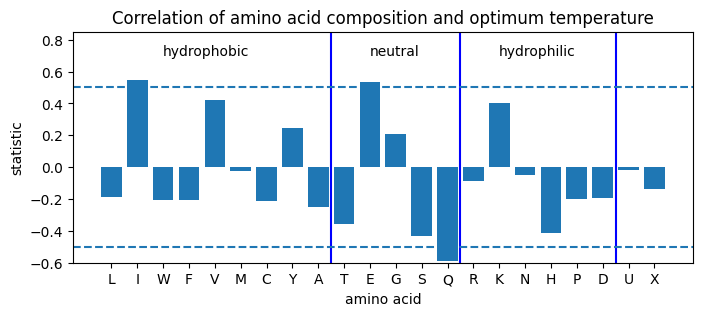

In [214]:
fig = plt.subplots(figsize=(8,3))
plt.bar(list(corr.index), corr.statistic)
plt.xlabel('amino acid')
plt.ylabel('statistic')
plt.title('Correlation of amino acid composition and optimum temperature')
plt.axvline(x = 8.5, color = 'b', ls='-', label = 'axvline - full height')
plt.axvline(x = 13.5, color = 'b', ls='-', label = 'axvline - full height')
plt.axvline(x = 19.5, color = 'b', ls='-', label = 'axvline - full height')
plt.axhline(y=.5, ls='--')
plt.axhline(y=-.5, ls='--')
plt.ylim(-0.6, 0.85)
plt.text(2,.7, 'hydrophobic')
plt.text(10,.7, 'neutral')
plt.text(15,.7, 'hydrophilic')
plt.show()